In [25]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

In [26]:
pip install openpyxl


Note: you may need to restart the kernel to use updated packages.


Exported reshaped long-format dataset for Power BI!


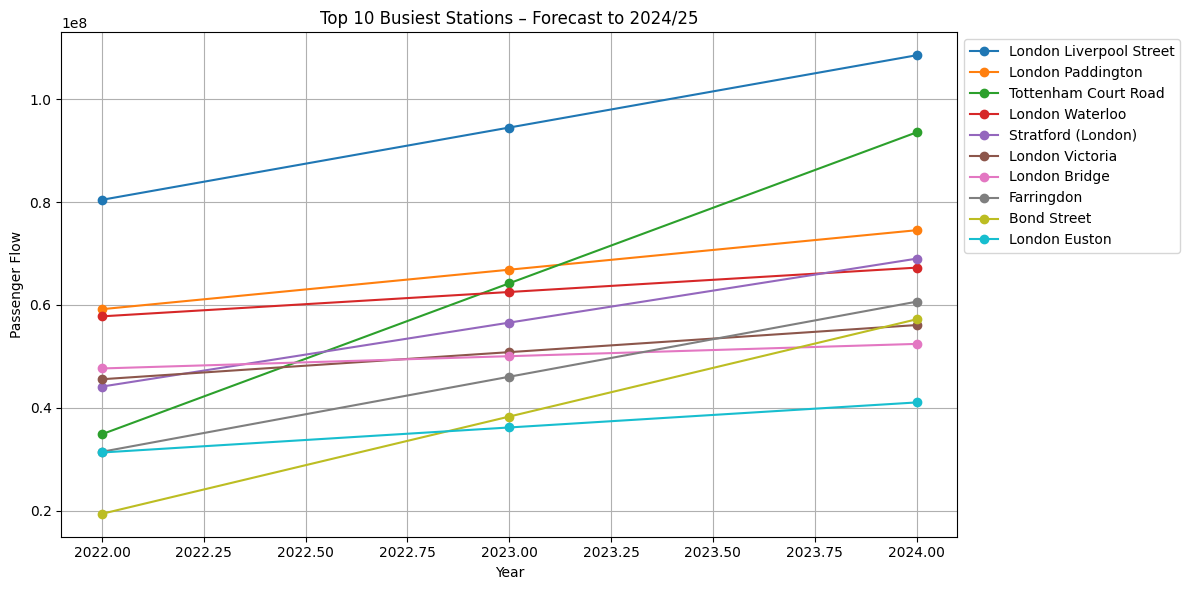

In [27]:
# Railway Passenger Flow Analysis (2022-2024)

# === 1. Load Datasets ===
file_2023 = 'Entries_Exits_Interchanges_2022-23.csv'
file_2024 = 'Entries_Exits_Interchanges_2023-24.csv'

# Read both CSVs
df_2023 = pd.read_csv(file_2023)
df_2024 = pd.read_csv(file_2024)

# Add year columns
df_2023['year'] = '2022-23'
df_2024['year'] = '2023-24'

# === 2. Standardize Column Names ===
df_2023.columns = df_2023.columns.str.strip().str.lower().str.replace(' ', '_')
df_2024.columns = df_2024.columns.str.strip().str.lower().str.replace(' ', '_')

# === 3. Combine Datasets ===
df = pd.concat([df_2023, df_2024], ignore_index=True)

# === 4. Standardize station names ===
df['station_name'] = df['station_name'].str.strip().str.lower()

# === 5. Enrich with Region Info ===
region_df = pd.read_excel('Region mapping.xlsx')
region_df.columns = region_df.columns.str.strip().str.lower()
region_df['station_name'] = region_df['station_name'].str.strip().str.lower()

# Merge with region info
df = df.merge(region_df[['station_name', 'region']], on='station_name', how='left')
#print(f"Region successfully mapped for {df['region'].notna().sum()} out of {len(df)} records.")

# === 6. Clean Data ===
to_numeric_cols = ['full_price_tickets', 'reduced_price_tickets', 'season_tickets', 'interchanges', 'total_entries_exits']
for col in to_numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# === 7. Basic Aggregation by Year and Station ===
total_by_station = df.groupby(['station_name', 'year'], as_index=False)[
    ['full_price_tickets', 'reduced_price_tickets', 'season_tickets', 'interchanges', 'total_entries_exits']
].sum()

# Reattach region info
total_by_station = total_by_station.merge(region_df[['station_name', 'region']], on='station_name', how='left')

# === 8. Year-on-Year Growth ===
yoy = total_by_station.pivot(index='station_name', columns='year', values='total_entries_exits').reset_index()
yoy.columns.name = None
yoy['growth_absolute'] = yoy['2023-24'] - yoy['2022-23']
yoy['growth_percent'] = ((yoy['2023-24'] - yoy['2022-23']) / yoy['2022-23']) * 100

# === 9. Forecast 2024-25 ===
yoy_forecast = yoy.dropna(subset=['2022-23', '2023-24']).copy()
forecast_values = []
for _, row in yoy_forecast.iterrows():
    X = np.array([[2022], [2023]])
    y = np.array([row['2022-23'], row['2023-24']])
    model = LinearRegression().fit(X, y)
    forecast_values.append(model.predict([[2024]])[0])

yoy_forecast['forecast_2024-25'] = forecast_values

# === 10. Prepare Long Format for Power BI ===
long_format = pd.melt(
    yoy_forecast,
    id_vars=['station_name'],
    value_vars=['2022-23', '2023-24', 'forecast_2024-25'],
    var_name='year',
    value_name='passenger_flow'
)

# Merge region info back in (optional but useful for maps/slicers)
long_format = long_format.merge(region_df[['station_name', 'region']], on='station_name', how='left')

# === 11. Export Long Format for Power BI ===
long_format.to_csv('passenger_flow_long.csv', index=False)
print("Exported reshaped long-format dataset for Power BI!")

# === 12. Plot Top 10 Forecast Stations ===
top_10 = yoy_forecast.sort_values(by='2023-24', ascending=False).head(10)
plt.figure(figsize=(12, 6))
for _, row in top_10.iterrows():
    plt.plot([2022, 2023, 2024], [row['2022-23'], row['2023-24'], row['forecast_2024-25']], marker='o', label=row['station_name'].title())

plt.title('Top 10 Busiest Stations – Forecast to 2024/25')
plt.xlabel('Year')
plt.ylabel('Passenger Flow')
plt.grid(True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [28]:
region_df.columns = region_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [29]:
print(region_df.head())


  station_name  region
0   abbey wood  London
1         aber   Wales
2     aberdare   Wales
3    aberdovey   Wales
4     abererch   Wales


In [30]:
print("Columns in 2022–23 data:", df_2023.columns.tolist())
print("Columns in 2023–24 data:", df_2024.columns.tolist())


Columns in 2022–23 data: ['station_name', 'full_price_tickets', 'reduced_price_tickets', 'season_tickets', 'total_entries_exits', 'interchanges', 'region', 'nlc_code', 'tlc_code', 'year']
Columns in 2023–24 data: ['station_name', 'full_price_tickets', 'reduced_price_tickets', 'season_tickets', 'total_entries_exits', 'interchanges', 'region', 'nlc_code', 'tlc_code', 'year']


In [31]:
print(df['station_name'].drop_duplicates().sample(10).tolist())

['brockenhurst', 'witley', 'sway', 'cricklewood', 'danescourt', 'chapelton (devon)', 'rugby', 'birchington-on-sea', 'corkickle', 'furze platt']
